Install this package to load the dataset directly

In [1]:
pip install -q git+https://github.com/eaedk/testing-zindi-package.git

Install this package for hparam tuning

In [2]:
pip install -q -U keras-tuner

Import everything that we need

In [13]:
from zindi.user import Zindian
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os
import statistics
import keras_tuner as kt
import tensorflow as tf

Sign in to Zindi account

In [4]:
zindi_username = "Marcus"
zindi_account = Zindian(username = zindi_username)

Your password
>> ··········

[ 🟢 ] 👋🏾👋🏾 Welcome Marcus 👋🏾👋🏾



Select the makerere-passion-fruit-disease-detection-challenge and show the details

In [5]:
zindi_account.select_a_challenge()
zindi_account.which_challenge

__________________________________________________________________________________________________________________________________
|     |              |                  |                    |          
|index|  challenge   |     problem      |       reward       |    id    
|     |              |                  |                    |          
----------------------------------------------------------------------------------------------------------------------------------
|  0  |Public Compet |  Classification  |     $5 000 USD     | kenyan-sign-language-classification-challenge...
----------------------------------------------------------------------------------------------------------------------------------
|  1  | Public Hack  |  Classification  |      $300 USD      | kenyan-sign-language-classification-hackathon...
----------------------------------------------------------------------------------------------------------------------------------
|  2  |Public Compet |  Classific

'makerere-passion-fruit-disease-detection-challenge'

Download and unzip the dataset

In [6]:
zindi_account.download_dataset(destination="dataset")
!unzip 'dataset/Train_Images.zip' -d ''
!unzip 'dataset/Test_Images.zip' -d ''

dataset/PassionfruitStarterNotebook.ipynb: 100%|██████████| 609k/609k [00:00<00:00, 12.7Mo/s]
dataset/Test.csv: 100%|██████████| 10.9k/10.9k [00:00<00:00, 2.35Mo/s]
dataset/Sample_submission.csv: 100%|██████████| 16.4k/16.4k [00:00<00:00, 3.99Mo/s]
dataset/Train_Images.zip: 100%|██████████| 293M/293M [00:08<00:00, 35.2Mo/s]
dataset/Test_Images.zip: 100%|██████████| 36.4M/36.4M [00:01<00:00, 35.2Mo/s]
dataset/Train.csv: 100%|██████████| 192k/192k [00:00<00:00, 6.29Mo/s]


Archive:  dataset/Train_Images.zip
replace __MACOSX/._Train_Images? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  dataset/Test_Images.zip
replace __MACOSX/._Test_Images? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Create a data frame with the columns we need

In [6]:
train_dir = 'dataset/Train.csv'
test_dir = 'dataset/Test.csv'
train_df = pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)
train_df['xmax'] = train_df['xmin']+train_df['width']
train_df['ymax'] = train_df['ymin']+train_df['height']
classes_la = {"fruit_brownspot": 1, "fruit_healthy": 2, "fruit_woodiness":3}
classes_la = {"fruit_brownspot": 1, "fruit_healthy": 2, "fruit_woodiness":3}
train_df["class"] = train_df["class"].apply(lambda x: classes_la[x])
df = train_df.copy()
df.drop('width', inplace=True, axis=1)
df.drop('height', inplace=True, axis=1)
df.head()

,Image_ID,class,xmin,ymin,xmax,ymax
0,ID_007FAIEI,3,87.0,87.5,315.0,398.5
1,ID_00G8K1V3,1,97.5,17.5,342.5,372.0
2,ID_00WROUT9,1,156.5,209.5,404.5,512.0
3,ID_00ZJEEK3,2,125.0,193.0,379.5,410.0
4,ID_018UIENR,1,79.5,232.5,313.0,414.5


Initialize and populate our lists of data, labels, bounding boxes and image paths

In [7]:
data = [] # list of images (in array form)
labels = [] # list of labels for each image
bboxes = [] # list of bounding boxes for each image
imagePaths = [] # list of paths for each image

df = df.to_numpy()
df = df.tolist()
for row in df:
  imageId, label, startX, startY, endX, endY = row
  imagePath = 'Train_Images/'+imageId + '.jpg'

  #load image
  image = cv2.imread(imagePath)
  (h,w) = image.shape[:2]

  #scale bounding boxes
  startX  = float(startX) / w
  startY  = float(startY) / h
  endX  = float(endX) / w
  endY  = float(endY) / h

  #load and preproess image
  image = load_img(imagePath, target_size=(224,224))
  image = img_to_array(image)

  #update
  data.append(image)
  labels.append(label)
  bboxes.append((startX, startY, endX, endY))
  imagePaths.append(imagePath)

Some pre-processing - scale image data between 0 and 1 and perform binary one-hot encoding on labels. We also need to convert to numpy arrays

In [8]:
data = np.array(data, dtype='float32')/255.0
labels = np.array(labels)
bboxes = np.array(bboxes,dtype='float32')
imagePaths = np.array(imagePaths)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

Perform training and testing split and define dictionaries

In [9]:
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=0.2, random_state=20)

(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

# a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# a second dictionary, this one for our target testing outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

Define a function to build our model, given a set of hyper-parameters



In [13]:
def get_model(hp):
	# Choose an optimal value for the number of units in the first hidden layer
	hp_first_units = hp.Int('first_units', min_value=16, max_value=64, step=16)
	# Choose an optimal value for the number of units in the second hidden layer
	hp_second_units = hp.Int('second_units', min_value=16, max_value=64, step=16)
	# Choose an optimal value from 0.01, 0.001, or 0.0001 for the learning rate
	hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

	# Convolutional layers
	rn50v2 = ResNet50V2(weights="imagenet", include_top=False,
		input_tensor=Input(shape=(224, 224, 3)))
	rn50v2.trainable = False
	flatten = rn50v2.output
	flatten = Flatten()(flatten)

	# branch for output of bounding box coordinates
	bboxHead = Dense(hp_first_units, activation="relu")(flatten)
	bboxHead = Dense(hp_second_units, activation="relu")(bboxHead)
	bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

	# branch for output of label
	softmaxHead = Dense(hp_first_units, activation="relu")(flatten)
	softmaxHead = Dropout(0.5)(softmaxHead)
	softmaxHead = Dense(hp_second_units, activation="relu")(softmaxHead)
	softmaxHead = Dropout(0.5)(softmaxHead)
	softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

	model = Model(inputs=rn50v2.input, outputs=(bboxHead, softmaxHead))
	losses = {"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error"}
	lossWeights = {"class_label": 1.0, "bounding_box": 1.0}
	opt = Adam(learning_rate=hp_learning_rate)
	model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
	return model

Tune the hyper-parameters using the hyperband tuner

In [15]:
tuner = kt.Hyperband(get_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='hp_tuning',
                     project_name='cos_711_assignment_3')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=32,
	epochs=10,
	verbose=1,
  callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

tuner.results_summary()

Results summary
Results in hp_tuning/cos_711_assignment_3
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
first_units: 48
second_units: 32
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: bfca5869210f551642f946e42c40b6d6
Score: 0.20852258801460266
Trial summary
Hyperparameters:
first_units: 48
second_units: 64
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: cbca625c76a5a482752f5fbb3b73642e
Score: 0.2089443951845169
Trial summary
Hyperparameters:
first_units: 48
second_units: 16
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 5fbde85174911115070d12a21990b790
Score: 0.29474472999572754
Trial summary
Hyperparameters:
first_units: 48
second_units: 48
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.36117705

Define function for best model now that we have the best hyper-parameters

In [10]:
def best_model():
	# Choose an optimal value for the number of units in the first hidden layer
	hp_first_units = 48
	# Choose an optimal value for the number of units in the second hidden layer
	hp_second_units = 32
	# Choose an optimal value from 0.01, 0.001, or 0.0001 for the learning rate
	hp_learning_rate = 1e-4

	# Convolutional layers
	rn50v2 = ResNet50V2(weights="imagenet", include_top=False,
		input_tensor=Input(shape=(224, 224, 3)))
	rn50v2.trainable = False
	flatten = rn50v2.output
	flatten = Flatten()(flatten)

	# branch for output of bounding box coordinates
	bboxHead = Dense(hp_first_units, activation="relu")(flatten)
	bboxHead = Dense(hp_second_units, activation="relu")(bboxHead)
	bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

	# branch for output of label
	softmaxHead = Dense(hp_first_units, activation="relu")(flatten)
	softmaxHead = Dropout(0.5)(softmaxHead)
	softmaxHead = Dense(hp_second_units, activation="relu")(softmaxHead)
	softmaxHead = Dropout(0.5)(softmaxHead)
	softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

	model = Model(inputs=rn50v2.input, outputs=(bboxHead, softmaxHead))
	losses = {"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error"}
	lossWeights = {"class_label": 1.0, "bounding_box": 1.0}
	opt = Adam(learning_rate=hp_learning_rate)
	model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
	return model

Run tests using the best hyperparamters

In [11]:
histories = []
for i in range(10):
  tf.keras.backend.clear_session()
  model = best_model()
  history = model.fit(trainImages, trainTargets,validation_data=(testImages, testTargets),batch_size=32,epochs=10,verbose=1)
  histories.append(history)

Epoch 1/10
98/98 [==============================] - 61s 278ms/step - loss: 1.0303 - bounding_box_loss: 0.0354 - class_label_loss: 0.9949 - bounding_box_accuracy: 0.6021 - class_label_accuracy: 0.5755 - val_loss: 0.5086 - val_bounding_box_loss: 0.0269 - val_class_label_loss: 0.4817 - val_bounding_box_accuracy: 0.6419 - val_class_label_accuracy: 0.8555
Epoch 2/10
98/98 [==============================] - 24s 242ms/step - loss: 0.7384 - bounding_box_loss: 0.0233 - class_label_loss: 0.7150 - bounding_box_accuracy: 0.7017 - class_label_accuracy: 0.6917 - val_loss: 0.4115 - val_bounding_box_loss: 0.0282 - val_class_label_loss: 0.3832 - val_bounding_box_accuracy: 0.6586 - val_class_label_accuracy: 0.9066
Epoch 3/10
98/98 [==============================] - 24s 244ms/step - loss: 0.6425 - bounding_box_loss: 0.0212 - class_label_loss: 0.6213 - bounding_box_accuracy: 0.7372 - class_label_accuracy: 0.7340 - val_loss: 0.3055 - val_bounding_box_loss: 0.0284 - val_class_label_loss: 0.2771 - val_boundi

Tabulate the results based on accuracy

In [19]:
lblTrainingAcc = statistics.mean(history.history['class_label_accuracy'][-1] for history in histories)
lblTrainingStd = statistics.stdev(history.history['class_label_accuracy'][-1] for history in histories)
lblValidationAcc = statistics.mean(history.history['val_class_label_accuracy'][-1] for history in histories)
lblValidationStd = statistics.stdev(history.history['val_class_label_accuracy'][-1] for history in histories)

bbTrainingAcc = statistics.mean(history.history['bounding_box_accuracy'][-1] for history in histories)
bbTrainingStd = statistics.stdev(history.history['bounding_box_accuracy'][-1] for history in histories)
bbValidationAcc = statistics.mean(history.history['val_bounding_box_accuracy'][-1] for history in histories)
bbValidationStd = statistics.stdev(history.history['val_bounding_box_accuracy'][-1] for history in histories)

table = [["Class Label",lblTrainingAcc,lblTrainingStd,lblValidationAcc,lblValidationStd],
         ["Bounding Box",bbTrainingAcc,bbTrainingStd,bbValidationAcc,bbValidationStd]]

print(tabulate(table, headers=["","Training\nAccuracy", "Training\nσ", "Validation\nAccuracy", "Validation\nσ"], tablefmt="fancy_grid"))

╒══════════════╤════════════╤════════════╤══════════════╤══════════════╕
│              │   Training │   Training │   Validation │   Validation │
│              │   Accuracy │          σ │     Accuracy │            σ │
╞══════════════╪════════════╪════════════╪══════════════╪══════════════╡
│ Class Label  │   0.817222 │  0.0489317 │     0.95098  │    0.0174557 │
├──────────────┼────────────┼────────────┼──────────────┼──────────────┤
│ Bounding Box │   0.798656 │  0.0142473 │     0.688406 │    0.0108759 │
╘══════════════╧════════════╧════════════╧══════════════╧══════════════╛


What about loss? How did loss progress during training.

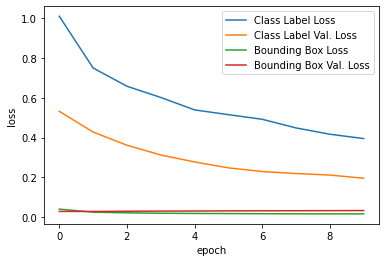

In [23]:
lblHistoriesList = list(map(lambda x: x.history['class_label_loss'], histories))
avgLblAccProgress = np.average(lblHistoriesList, axis=0)
lblValHistoriesList = list(map(lambda x: x.history['val_class_label_loss'], histories))
avgLblValAccProgress = np.average(lblValHistoriesList, axis=0)
bbHistoriesList = list(map(lambda x: x.history['bounding_box_loss'], histories))
avgBbAccProgress = np.average(bbHistoriesList, axis=0)
bbValHistoriesList = list(map(lambda x: x.history['val_bounding_box_loss'], histories))
avgBbValAccProgress = np.average(bbValHistoriesList, axis=0)

plt.plot(avgLblAccProgress, label='Class Label Loss')
plt.plot(avgLblValAccProgress, label='Class Label Val. Loss')
plt.plot(avgBbAccProgress, label='Bounding Box Loss')
plt.plot(avgBbValAccProgress, label='Bounding Box Val. Loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

Create a submission for testing on Zindi

In [25]:
model = best_model()
history = model.fit(trainImages, trainTargets,validation_data=(testImages, testTargets),batch_size=32,epochs=10,verbose=1)
test_images_dir = 'Test_Images/'
test_df.head()
testImageIds = test_df['Image_ID'].to_numpy().tolist()
testImageIds
ids = []
label = []
xmin = []
confidence = []
ymin =[]
xmax= []
ymax=[]
count = 0
for tid in testImageIds:
  imagePath = test_images_dir+tid+'.jpg'
  image = load_img(imagePath, target_size=(224,224))
  image = img_to_array(image)
  image = np.array(image, dtype='float32')/255.0
  image = np.expand_dims(image,axis=0)
  prediction = model.predict(image)
  startX,startY,endX,endY = prediction[0][0]
  image = cv2.imread(imagePath)
  (h,w) = image.shape[:2]
  xmin.append(startX*w)
  ymin.append(startY*h)
  xmax.append(endX*w)
  ymax.append(endY*h)
  ids.append(tid)
  ce = np.amax(prediction[1][0])
  confidence.append(ce)
  idx = np.argmax(prediction[1][0])
  classes = ["fruit_brownspot","fruit_healthy","fruit_woodiness"]
  label.append(classes[idx])
  count += 1
#data transform

Epoch 1/10
98/98 [==============================] - 29s 257ms/step - loss: 1.0802 - bounding_box_loss: 0.0395 - class_label_loss: 1.0407 - bounding_box_accuracy: 0.6354 - class_label_accuracy: 0.5637 - val_loss: 0.6400 - val_bounding_box_loss: 0.0321 - val_class_label_loss: 0.6079 - val_bounding_box_accuracy: 0.6726 - val_class_label_accuracy: 0.7852
Epoch 2/10
98/98 [==============================] - 24s 244ms/step - loss: 0.7917 - bounding_box_loss: 0.0259 - class_label_loss: 0.7658 - bounding_box_accuracy: 0.7013 - class_label_accuracy: 0.6975 - val_loss: 0.5514 - val_bounding_box_loss: 0.0291 - val_class_label_loss: 0.5224 - val_bounding_box_accuracy: 0.6445 - val_class_label_accuracy: 0.8414
Epoch 3/10
98/98 [==============================] - 24s 245ms/step - loss: 0.7418 - bounding_box_loss: 0.0225 - class_label_loss: 0.7193 - bounding_box_accuracy: 0.7286 - class_label_accuracy: 0.7561 - val_loss: 0.4898 - val_bounding_box_loss: 0.0303 - val_class_label_loss: 0.4595 - val_boundi

In [ ]:
solution = pd.DataFrame({'Image_ID':ids})
solution['class'] = label
solution['confidence'] = confidence
solution['ymin'] = ymin
solution['xmin'] = xmin
solution['ymax'] = ymax
solution['xmax'] = xmax


In [ ]:
submission = solution.copy()

In [ ]:
submission.rename({0:'Image_ID'},axis='index')
submission.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,ID_IUJJG62B,fruit_healthy,1.000000,279.840240,289.366791,426.820618,460.809418
1,ID_ZPNDRD4T,fruit_healthy,0.999998,263.239075,125.332031,404.609070,268.275757
2,ID_AHFYB64P,fruit_woodiness,0.999990,227.531403,217.595474,434.598969,378.175995
3,ID_L8JZLNTF,fruit_healthy,1.000000,182.103851,118.848465,410.043030,349.787415
4,ID_IFMUXGPL,fruit_woodiness,1.000000,157.412552,248.510040,343.166901,394.465088


In [ ]:
submission.to_csv('submission.csv', index=False)
